In [34]:
from examples.seismic import Model, plot_velocity,demo_model,TimeAxis,RickerSource,Receiver
from devito import TimeFunction,Eq,solve,Operator
import numpy as np



In [33]:
N=(401,401);
model = demo_model('layers-isotropic',             # A velocity model.
                   nlayers=2,
                   shape=N,  # Number of grid points.
                   spacing=(7.5, 7.5),  # Grid spacing in m.
                   nbl=80, space_order=8)      # boundary layer.
vp = model.vp.data

Operator `initdamp` ran in 0.01 s


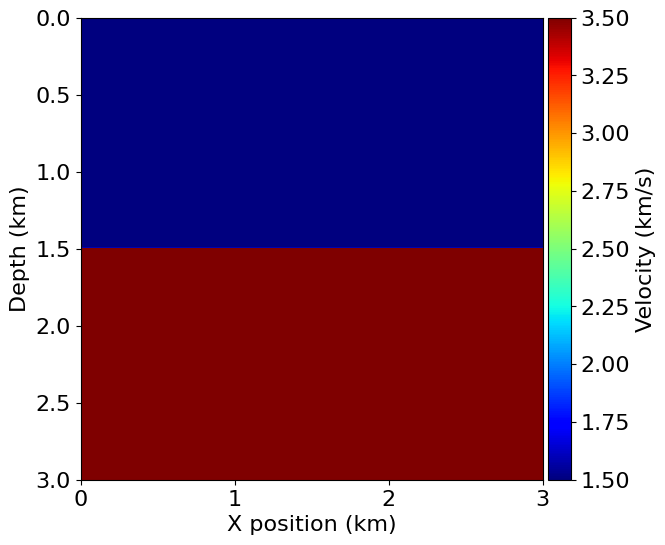

In [8]:
plot_velocity(model)

In [15]:
from devito import TimeFunction
from examples.seismic import TimeAxis

t0 = 0.     # Simulation starts a t=0
tn = 3000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing

time = TimeAxis(start=t0, stop=tn, step=dt)

In [16]:
u = TimeFunction(name="u", grid=model.grid, 
                 time_order=2, space_order=8,
                 save=time.num)

In [17]:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

In [18]:
stencil = Eq(u.forward, solve(pde, u.forward))
stencil

Eq(u(time + dt, x, y), (-(-2.0*u(time, x, y)/dt**2 + u(time - dt, x, y)/dt**2)/vp(x, y)**2 + Derivative(u(time, x, y), (x, 2)) + Derivative(u(time, x, y), (y, 2)) + damp(x, y)*u(time, x, y)/dt)/(damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))

In [57]:
from examples.seismic import RickerSource

# Src is halfway across model, at depth of 20 m.
x_extent, _ = model.domain_size
src_coords = [x_extent/2, 20]

f0 = 0.025  # kHz, peak frequency.
src = RickerSource(name='src', grid=model.grid, f0=f0, coordinates=src_coords, time_range=time)

In [35]:
stencil = Eq(u.forward, solve(pde, u.forward))

In [25]:
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

In [41]:
x_locs = np.linspace(0, x_extent, 42)
rec_coords = [(x, 20) for x in x_locs]
rec = Receiver(name='rec', npoint=42, grid=model.grid, coordinates=rec_coords, time_range=time)
rec_term = rec.interpolate(u)

In [43]:
op_fwd = Operator([stencil] + src_term + rec_term)

In [44]:
op_fwd(dt=model.critical_dt)

Operator `Kernel` ran in 0.79 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.7122479999999971, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.034297000000000195, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0383240000000001, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [45]:
rec.data.shape

(2699, 42)

In [46]:
n,m=rec.data.shape


In [53]:
travel_times=np.zeros(42)
for i in range(0,m) :
    for j in range(0,n):
        if rec.data[j,i]>0.1:  
            travel_times[i]=j*dt
            break
travel_times=travel_times/1000

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

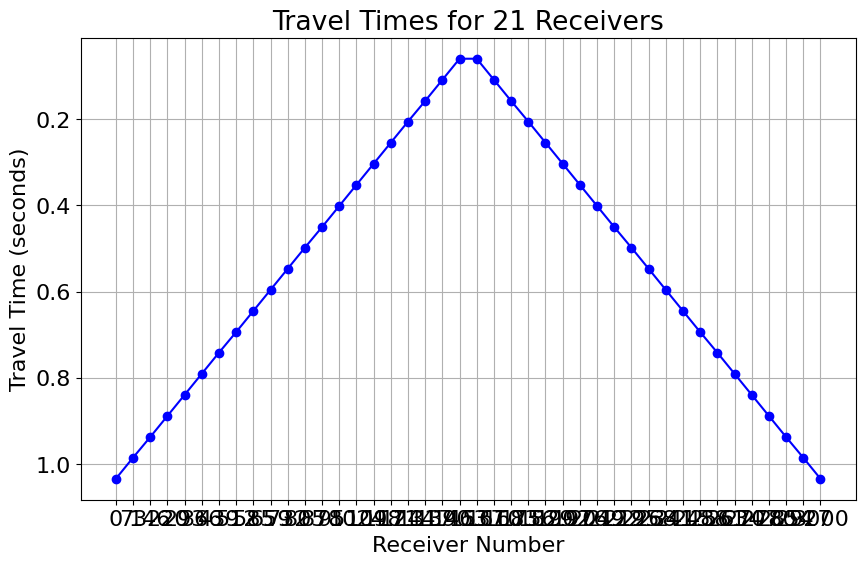

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(rec.coordinates.data[:, 0] , travel_times, marker='o', linestyle='-', color='b')
plt.title('Travel Times for 21 Receivers')
plt.xlabel('Receiver Number')
plt.ylabel('Travel Time (seconds)')
plt.grid(True)
plt.xticks(rec.coordinates.data[:, 0])  # Show all receiver numbers on the x-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()

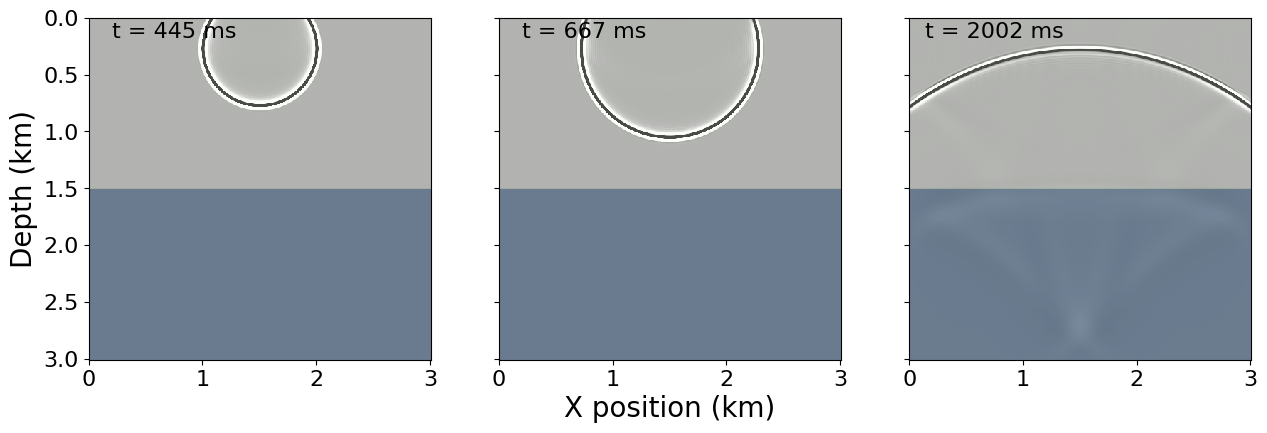

In [58]:
from matplotlib import cm
fig = plt.figure(figsize=(15, 5))

times = [400, 600, 1800]

extent = [model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
          model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]]

data_param = dict(vmin=-1e-1, vmax=1e-1, cmap=cm.Greys, aspect=1, extent=extent, interpolation='none')
model_param = dict(vmin=1.5, vmax=3.5, cmap=cm.GnBu, aspect=1, extent=extent, alpha=.3)

ax0 = fig.add_subplot(131)
_ = plt.imshow(np.transpose(u.data[times[0],40:-40,40:-40]), **data_param)
_ = plt.imshow(np.transpose(vp), **model_param)
ax0.set_ylabel('Depth (km)',  fontsize=20)
ax0.text(0.75, 0.18, "t = {:.0f} ms".format(time.time_values[times[0]]), ha="center", color='k')

ax1 = fig.add_subplot(132)
_ = plt.imshow(np.transpose(u.data[times[1],40:-40,40:-40]), **data_param)
_ = plt.imshow(np.transpose(vp), **model_param)
ax1.set_xlabel('X position (km)',  fontsize=20)
ax1.set_yticklabels([])
ax1.text(0.75, 0.18, "t = {:.0f} ms".format(time.time_values[times[1]]), ha="center", color='k')

ax2 = fig.add_subplot(133)
_ = plt.imshow(np.transpose(u.data[times[2],40:-40,40:-40]), **data_param)
_ = plt.imshow(np.transpose(vp), **model_param)
ax2.set_yticklabels([])
ax2.text(0.75, 0.18, "t = {:.0f} ms".format(time.time_values[times[2]]), ha="center", color='k')

plt.savefig("Figure3.pdf")
plt.savefig("Figure3.png", dpi=400)
plt.show()

In [56]:
import matplotlib.animation as animation
from IPython.display import HTML

nt = time.num

fig = plt.figure()
im = plt.imshow(np.transpose(u.data[0,40:-40,40:-40]),
                cmap="Greys", animated=True, vmin=-1e-1, vmax=1e-1, aspect=1,
                extent=[model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
                        model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]])
plt.xlabel('X position (km)',  fontsize=20)
plt.ylabel('Depth (km)',  fontsize=20)
plt.tick_params(labelsize=20)
im2 = plt.imshow(np.transpose(vp), vmin=1.5, vmax=3.5, cmap=cm.GnBu, aspect=1,
                 extent=[model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
                         model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]], alpha=.4)
def updatefig(i):
    im.set_array(np.transpose(u.data[i*5,40:-40,40:-40]))
    return im, im2

ani = animation.FuncAnimation(fig, updatefig, frames=np.linspace(0, nt/5-1, nt//5, dtype=np.int64), blit=True, interval=50)
plt.close(ani._fig)
HTML(ani.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available